In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pyspark
import pyspark.sql.functions 

In [2]:
# read in data to pandas
fake = pd.read_csv('fake.csv')
news = pd.read_csv('true.csv')

In [3]:
news

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
# create new columns in each to store the value of articles realness
news['is_fake'] = 0 # contains only news
fake['is_fake'] = 1 # contains only fakes

In [6]:
data = pd.concat([news, fake])
data = data.reset_index()
data = data.sample(frac=1)
data.head()

,index,title,text,subject,date,is_fake
17461,17461,Factbox: German coalition watch - Let's not be...,BERLIN (Reuters) - Chancellor Angela Merkel wo...,worldnews,"October 14, 2017",0
7903,7903,Obama casts early vote for 2016 election durin...,CHICAGO (Reuters) - President Barack Obama on ...,politicsNews,"October 7, 2016",0
3261,3261,Bernie Sanders urges progressives to seek more...,CHICAGO (Reuters) - Buoyed by the British Labo...,politicsNews,"June 11, 2017",0
8603,8603,White House says no politics in U.S. cyber thr...,WASHINGTON (Reuters) - The White House said on...,politicsNews,"July 28, 2016",0
22260,843,Fox News Just Shared A Poll That Trump Is Goi...,"On Sunday, Fox News had a rare moment of clari...",News,"July 16, 2017",1


In [7]:
data = data.drop(['date', 'index'], axis = 1)
data.reset_index(drop = True)
data.head()

,title,text,subject,is_fake
17461,Factbox: German coalition watch - Let's not be...,BERLIN (Reuters) - Chancellor Angela Merkel wo...,worldnews,0
7903,Obama casts early vote for 2016 election durin...,CHICAGO (Reuters) - President Barack Obama on ...,politicsNews,0
3261,Bernie Sanders urges progressives to seek more...,CHICAGO (Reuters) - Buoyed by the British Labo...,politicsNews,0
8603,White House says no politics in U.S. cyber thr...,WASHINGTON (Reuters) - The White House said on...,politicsNews,0
22260,Fox News Just Shared A Poll That Trump Is Goi...,"On Sunday, Fox News had a rare moment of clari...",News,1


In [8]:
data['text'] = data['title'] + " " + data['text']
data.head()

,title,text,subject,is_fake
17461,Factbox: German coalition watch - Let's not be...,Factbox: German coalition watch - Let's not be...,worldnews,0
7903,Obama casts early vote for 2016 election durin...,Obama casts early vote for 2016 election durin...,politicsNews,0
3261,Bernie Sanders urges progressives to seek more...,Bernie Sanders urges progressives to seek more...,politicsNews,0
8603,White House says no politics in U.S. cyber thr...,White House says no politics in U.S. cyber thr...,politicsNews,0
22260,Fox News Just Shared A Poll That Trump Is Goi...,Fox News Just Shared A Poll That Trump Is Goi...,News,1


In [9]:
data = data.drop(['title'], axis=1)
data

,text,subject,is_fake
17461,Factbox: German coalition watch - Let's not be...,worldnews,0
7903,Obama casts early vote for 2016 election durin...,politicsNews,0
3261,Bernie Sanders urges progressives to seek more...,politicsNews,0
8603,White House says no politics in U.S. cyber thr...,politicsNews,0
22260,Fox News Just Shared A Poll That Trump Is Goi...,News,1
...,...,...,...
3692,Senators raise alarms about shelving retiremen...,politicsNews,0
12382,Facebook says Russian-linked accounts spent ju...,worldnews,0
12475,"Two dead in Gaza blast, Israeli military denie...",worldnews,0
5771,Trump blasts media at Black History Month even...,politicsNews,0


In [10]:
subdata = data[0:5000]
subdata

,text,subject,is_fake
17461,Factbox: German coalition watch - Let's not be...,worldnews,0
7903,Obama casts early vote for 2016 election durin...,politicsNews,0
3261,Bernie Sanders urges progressives to seek more...,politicsNews,0
8603,White House says no politics in U.S. cyber thr...,politicsNews,0
22260,Fox News Just Shared A Poll That Trump Is Goi...,News,1
...,...,...,...
7492,Clinton campaign reached 25 percent of U.S. vo...,politicsNews,0
31875,TRUMP EXPOSES OBAMA’S INCOMPETENCE: Cuts EPA B...,politics,1
35982,UPDATE: CRUZ COMMENTS On His Desperate Vote Sh...,politics,1
19528,Indigenous protesters seize oil wells in Peruv...,worldnews,0


In [11]:
cloudtext = ' '.join(subdata['text'].tolist())

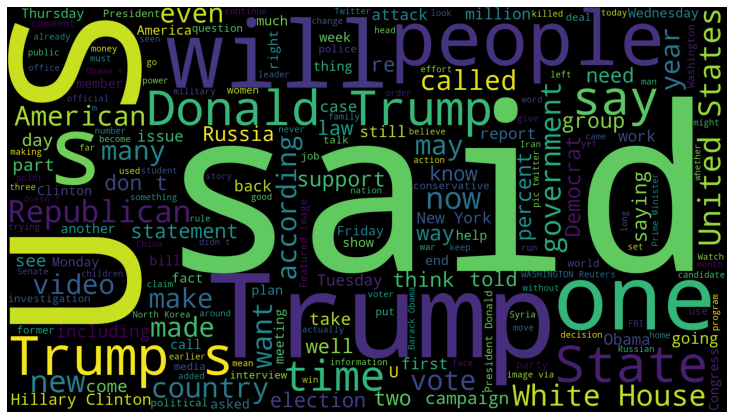

In [12]:
wordcloud = WordCloud(width=1920, height=1080).generate(cloudtext)
fig = plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [13]:
subdata = subdata.drop(['subject'], axis =1)
subdata

,text,is_fake
17461,Factbox: German coalition watch - Let's not be...,0
7903,Obama casts early vote for 2016 election durin...,0
3261,Bernie Sanders urges progressives to seek more...,0
8603,White House says no politics in U.S. cyber thr...,0
22260,Fox News Just Shared A Poll That Trump Is Goi...,1
...,...,...
7492,Clinton campaign reached 25 percent of U.S. vo...,0
31875,TRUMP EXPOSES OBAMA’S INCOMPETENCE: Cuts EPA B...,1
35982,UPDATE: CRUZ COMMENTS On His Desperate Vote Sh...,1
19528,Indigenous protesters seize oil wells in Peruv...,0


In [14]:
subdata = subdata.reindex(columns= ['is_fake', 'text'])
subdata

,is_fake,text
17461,0,Factbox: German coalition watch - Let's not be...
7903,0,Obama casts early vote for 2016 election durin...
3261,0,Bernie Sanders urges progressives to seek more...
8603,0,White House says no politics in U.S. cyber thr...
22260,1,Fox News Just Shared A Poll That Trump Is Goi...
...,...,...
7492,0,Clinton campaign reached 25 percent of U.S. vo...
31875,1,TRUMP EXPOSES OBAMA’S INCOMPETENCE: Cuts EPA B...
35982,1,UPDATE: CRUZ COMMENTS On His Desperate Vote Sh...
19528,0,Indigenous protesters seize oil wells in Peruv...


In [15]:
df = subdata.rename(columns={'is_fake': 'class'})
df

,class,text
17461,0,Factbox: German coalition watch - Let's not be...
7903,0,Obama casts early vote for 2016 election durin...
3261,0,Bernie Sanders urges progressives to seek more...
8603,0,White House says no politics in U.S. cyber thr...
22260,1,Fox News Just Shared A Poll That Trump Is Goi...
...,...,...
7492,0,Clinton campaign reached 25 percent of U.S. vo...
31875,1,TRUMP EXPOSES OBAMA’S INCOMPETENCE: Cuts EPA B...
35982,1,UPDATE: CRUZ COMMENTS On His Desperate Vote Sh...
19528,0,Indigenous protesters seize oil wells in Peruv...


In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
X = subdata.iloc[:, :-1].values
X[0]

array([0], dtype=int64)

In [19]:
y = subdata.iloc[:,-1].values
y[0]

"Factbox: German coalition watch - Let's not be perfectionists in coalition talks, says Merkel ally BERLIN (Reuters) - Chancellor Angela Merkel won a fourth term in office in the German national election on Sept. 24, but a fractured vote that brings the far-right into parliament means she must try to work out a three-way coalition untested at federal level. The new alliance would comprise Merkel s conservative bloc - her Christian Democratic Union (CDU) and the Bavarian Christian Social Union (CSU) - along with the pro-business Free Democrats (FDP) and environmentalist Greens. Such a tie-up is called a  Jamaica  coalition, because the three parties  colors of black, yellow and green match those of the Jamaican flag. To secure a coalition agreement, the unlikely bedfellows must overcome differences on a range of issues including immigration policy, Europe, tax and the environment. The CDU and CSU have reached an agreement over immigration policy, but it is not clear whether it will pass

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')
clean_up

VectorAssembler_ca9346f5e610

In [18]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [19]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)
cleaned.head()

Row(class=1, text='DINESH D’SOUZA BRILLIANTLY Schools Hollywood Reporter On Why Racist Democrats Keep Minorities On The Plantation [VIDEO] If you haven t seen Dinesh D Souza s  HILLARY S AMERICA  yet, it is a MUST see! Watch here, as Dinesh explains why his historically correct movie casts the truth on the Democrats racist roots, discusses his time in prison and much more  THE SOUND STARTS AT THE 1:00 MARK WHEN D SOUZA BEGINS TO SPEAK: ', length=421, label=0.0, token_text=['dinesh', 'd’souza', 'brilliantly', 'schools', 'hollywood', 'reporter', 'on', 'why', 'racist', 'democrats', 'keep', 'minorities', 'on', 'the', 'plantation', '[video]', 'if', 'you', 'haven', 't', 'seen', 'dinesh', 'd', 'souza', 's', '', 'hillary', 's', 'america', '', 'yet,', 'it', 'is', 'a', 'must', 'see!', 'watch', 'here,', 'as', 'dinesh', 'explains', 'why', 'his', 'historically', 'correct', 'movie', 'casts', 'the', 'truth', 'on', 'the', 'democrats', 'racist', 'roots,', 'discusses', 'his', 'time', 'in', 'prison', 'an

In [20]:
# Show label and resulting features
cleaned.select(['label', 'features']).show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
from pyspark.ml.classification import NaiveBayes
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [22]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|class|                text|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    0|"It would be huge...|  6956|  1.0|["it, would, be, ...|["it, huge":, u.s...|(262144,[1272,230...|(262144,[1272,230...|(262145,[1272,230...|[-39013.436822568...|           [0.0,1.0]|       1.0|
|    0|"Nobody stood wit...|  1672|  1.0|["nobody, stood, ...|["nobody, stood, ...|(262144,[1921,256...|(262144,[1921,256...|(262145,[1921,256...|[-8357.8080333684...|   [2.0153E-320,1.0]|       1.0|


In [23]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting Fake News was: %f" % acc)

Accuracy of model at predicting Fake News was: 0.981087
